Course: https://www.udemy.com/course/time-series-analysis/

# Section 4: Exponential Smoothing and EST Methods

- The data for this course is available at: https://docs.google.com/document/d/1SiG1V325FQ4bqhUFEoXGhkAK89RSS0tplcJBCuivn_s/edit?usp=sharing

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# SMA Code
- Exploring Simple Moving Average 

In [3]:
!wget -nc https://lazyprogrammer.me/course_files/sp500_close.csv

--2022-10-14 15:46:18--  https://lazyprogrammer.me/course_files/sp500_close.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 2606:4700:3030::ac43:d5a6, 2606:4700:3031::6815:17d2, 104.21.23.210, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|2606:4700:3030::ac43:d5a6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4143332 (4.0M) [text/csv]
Saving to: ‘sp500_close.csv’

sp500_close.csv     100%[===================>]   3.95M   249KB/s    in 9.4s    

2022-10-14 15:46:28 (433 KB/s) - ‘sp500_close.csv’ saved [4143332/4143332]



In [4]:
close = pd.read_csv('sp500_close.csv',index_col=0,parse_dates=True)
close.head()

,AAL,AAPL,AAP,ABBV,ABC,ABT,ACN,ADBE,ADI,ADM,...,XLNX,XL,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
2013-02-08,14.75,67.8542,78.90,36.25,46.89,34.41,73.31,39.12,45.70,30.22,...,37.51,28.24,88.61,42.87,31.84,27.09,65.30,75.85,24.14,33.05
2013-02-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-02-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-02-11,14.46,68.5614,78.39,35.85,46.76,34.26,73.07,38.64,46.08,30.28,...,37.46,28.31,88.28,42.84,31.96,27.46,64.55,75.65,24.21,33.26
2013-02-12,14.27,66.8428,78.60,35.42,46.96,34.30,73.37,38.89,46.27,30.81,...,37.58,28.41,88.46,42.87,31.84,27.95,64.75,75.44,24.49,33.74


- Get Google closing prices

In [8]:
goog = close[['GOOG']].copy().dropna()
goog.head()

,GOOG
2014-03-27,558.46
2014-03-28,559.99
2014-03-31,556.97
2014-04-01,567.16
2014-04-02,567.00


Text(0, 0.5, 'Closing Stock Prices')

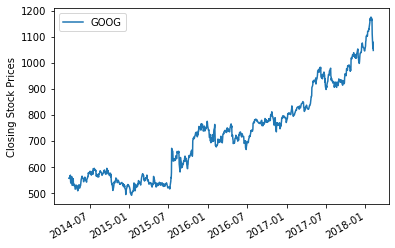

In [10]:
goog.plot()
plt.ylabel('Closing Stock Prices')

- Calculate log returns: $r_t = \log(1+R_t)=\log\left(1+\frac{P_t-P_{t-1}}{P_t}\right)$
- But the latter term in the sum is just the percent change of the price so:

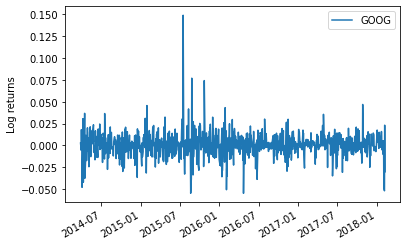

In [16]:
goog_ret = np.log(1+goog.pct_change(1))
goog_ret.plot()

# plot it
plt.ylabel('Log returns')
plt.show()

- Add SMA to google price df for two window sizes: 10 and 50
- Note that rolling() returns a pd Rolling object

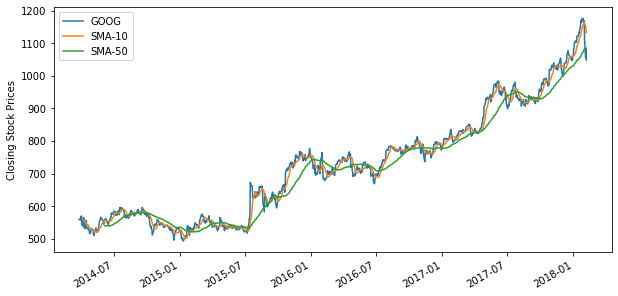

In [21]:
goog['SMA-10'] = goog['GOOG'].rolling(10).mean()
goog['SMA-50'] = goog['GOOG'].rolling(50).mean()

# Plot them
plt.figure(figsize=(10,5))
goog['GOOG'].plot()
goog['SMA-10'].plot()
goog['SMA-50'].plot()
plt.ylabel('Closing Stock Prices')
plt.legend()
plt.show()

- Note how the larger the window size, the more the SMA "lags" behind (most noticeable in the peaks)
    - This makes sense as all points in the window are equally weighted, so larger window size carries an average that is mostly representative of long term trends
    - Shorter term trends (e.g spikes) can either be washed out if they're short enough or will only be reflected in the SMA once/if many such points have been taken into account
- The next exercise for this section is to repeat the same thing but with Google and Apple prices at once. Since it's the same exercise but using a df with two columns instead of one, I omit it as uninstructive

# EWMA Code
- Explore exponentially weights moving average
- Apply exponentially moving average to number of monthly passengers data

In [22]:
!wget -nc https://lazyprogrammer.me/course_files/airline_passengers.csv

--2022-10-14 17:48:47--  https://lazyprogrammer.me/course_files/airline_passengers.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 2606:4700:3030::ac43:d5a6, 2606:4700:3031::6815:17d2, 104.21.23.210, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|2606:4700:3030::ac43:d5a6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2036 (2.0K) [text/csv]
Saving to: ‘airline_passengers.csv’

airline_passengers. 100%[===================>]   1.99K  --.-KB/s    in 0s      

2022-10-14 17:48:47 (12.4 MB/s) - ‘airline_passengers.csv’ saved [2036/2036]



In [23]:
df = pd.read_csv('airline_passengers.csv',index_col='Month',parse_dates=True)
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


- Use pandas ewm to perform EWMA:

In [27]:
alpha = 0.2 # randomly picked by instructor. Since alpha is low, resulting curve should be smooth

df['EWMA'] = df['Passengers'].ewm(alpha=alpha,adjust=False).mean() # adjust = False to use EWMA as described in lecture

<Figure size 720x360 with 0 Axes>

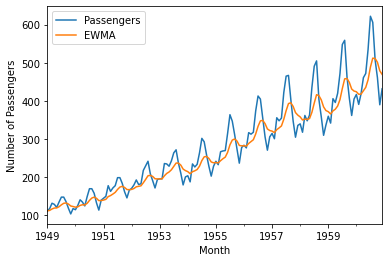

In [29]:
plt.figure(figsize=(10,5))
df.plot()
plt.ylabel('Number of Passengers')
plt.show()

- Now, compute EWMA manually and check that it's equal to pandas implementation:

In [34]:
manual_ewma = []
for i in df['Passengers'].to_numpy():
    if len(manual_ewma)>0:
        x_bar = alpha*i + (1-alpha)*manual_ewma[-1]
    else:
        x_bar = i # initialize with first value, could be any value but this makes sense
    manual_ewma.append(x_bar)

df['Manual_EWMA'] = manual_ewma

<Figure size 432x288 with 0 Axes>

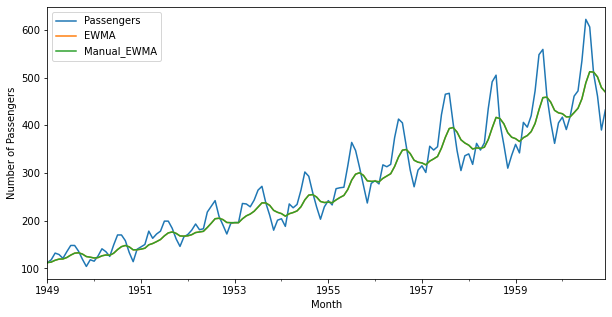

In [38]:
plt.figure()
df.plot(figsize=(10,5))
plt.ylabel('Number of Passengers')
plt.show()

- The manual and pandas-computed EWMA are the same (curves lie on top of each other)
    - Can further check per entry in df but omitting for brevity
- Clear manual calculation to clean up df:

In [39]:
df.drop('Manual_EWMA',axis=1,inplace=True)

In [40]:
df.columns

Index(['Passengers', 'EWMA'], dtype='object')